<a href="https://colab.research.google.com/github/geunsu-jo/Hands-On-ML/blob/main/textbook_practice/07_ensemble_and_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 앙상블 학습

여러 예측기로 부터 예측 결과를 수집하여, 더 좋은 예측을 얻는 방법. <br>
__배깅__, __부스팅__, __스태킹__ 등이 있다.

샘플 생성

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## 투표 기반 분류기

__직접 투표기__ : 각 분류기의 다수결 투표로 정해지는 분류기 <br>
__간접 투표기__ : 개별 분류기의 확률을 예측할 수 있다면(__predcit_proba()__ 메서드가 있으면), 클래스 별 예측 확률을 평균을 내어, 가장 높은 클래스를 선택하는 분류기

__직접 투표__

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="newton-cg", random_state=42) # solver ="lbfgs" is default
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)  # if gamma = "scale", 1 / (n_features * X.var()), if gamma = "auto", 1 / n_features

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

- voting='hard'는 직접 투표(default)
- voting='soft'는 간접 투표

In [73]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='newton-cg', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,...
                                        

In [74]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


- 각 개별 분류기보다 voting 결과가 더 높음을 알 수 있다.

__간접 투표__

In [75]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## 배깅과 페이스팅

__배깅__ : 중복을 허용하여 리샘플링 후, 샘플마다 같은 알고리즘을 각각 다르게 학습 <br>
__페이스팅__ : 중복을 허용하지 않고 리샘플링 후, 샘플마다 같은 알고리즘을 각각 다르게 학습

분류 문제에서 배깅과 페이스팅은 통계적 최빈값을 클래스로 예측(직접 투표와 같이)하고, 회귀 문제에서는 평균을 계산


### 사이킷런에서 배깅과 페이스팅

사이킷런에서 __BaggingClassifier__(회귀는 BaggingRegressor) 클래스를 사용하여 배깅과 페이스팅 구현가능

In [76]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42, n_jobs=-1)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

- __n_jobs__ 는 훈련과 예측에 사용할 CPU 코어 수를 지정(-1일 경우 가용한 모든 코어 사용)
- __bootstrap=True__ 이면 배깅이고, False이면 페이스팅

In [77]:
from sklearn.metrics import accuracy_score

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_tree))
print(accuracy_score(y_test, y_pred))

0.856
0.904


- 개별 트리보다, 트리를 배깅한 것이 더 높은 예측률

훈련 데이터로부터 학습된 개별 트리와, 배깅의 결정경계 시각화

In [78]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

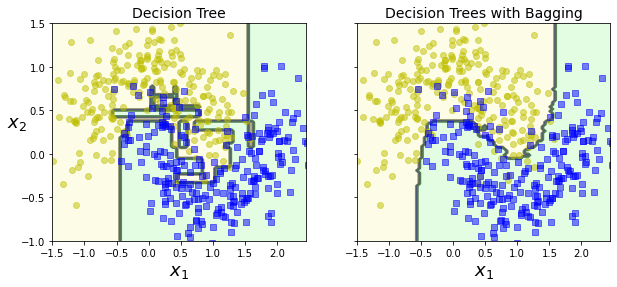

In [79]:
import matplotlib.pyplot as plt
import numpy as np

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

plt.show()

### OOB 평가

배깅 방법을 적용할 때, 리샘플링 되지 않은 샘플들로 모델을 평가하는 방법. 중복을 허용하여 리샘플링을 할 때, 대략 63%정도 샘플링되고 남은 37%로 모델을 평가한다. 여기서 나머지 37% 샘플을 oob(out-of-bag) sample이라 부른다.

사이킷런에서 __BaggingClassifer__를 만들때 __oob_score=True__로 지정하면, 자동으로 oob 평가 수행. (개별 분류기의 oob 평가를 평균내어 반환)

In [80]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)

bag_clf.oob_score_

0.9013333333333333

- oob sample을 통해 검증 결과, 90.1%의 정확도를 보임

In [81]:
bag_clf.oob_decision_function_[0:10,]

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637]])

- 각 훈련 샘플에서 oob 평가를 통해, 클래스의 확률을 반환.
- 예를 들어 첫 샘플이 oob 평가에 사용될 때, 음성으로 예측한 확률은 0.31, 양성으로 예측한 확률은 0.68

테스트 세트로 평가해보자.

In [82]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

## 랜덤 패치와 랜덤 서브스페이스

__랜덤 패치 방식__ : 훈련 샘플과 훈련 특성(feature)를 모두 사용하는 방식 <br>
__랜덤 서브 스페이스__ : 훈련 샘플은 모두 사용하고(중복 허용), 훈련 특성은 일부만 뽑아 사용하는 방식 <br>


특성을 서브 샘플링할 경우 분산은 낮추는 대신, 편향은 증가

## 랜덤 포레스트

배깅과 거의 유사하나, 각 Decision tree에 사용되는 특성을 random하게 선택한다. 즉, 편향을 높이더라도 분산을 더 낮추는 방법. <br>
__max_features="auto"__ 면(default), 트리를 만들때 사용되는 특성은 sqrt(n)개

In [83]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [84]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_rf)

0.912

### 엑스트라 트리

랜덤 포레스트보다 분산을 더 낮추는 극단적인 방법. <br>
각 트리에서 노드를 분할 할 때, 1개의 특성을 무작위적으로 선택한 다음 최적의 임곗값을 구함(랜덤 포레스트는 모든 특성에 대해 최적의 임계값을 구함) <br>
따라서, 랜덤포레스트에 비해 편향은 높으나 분산을 낮추고 계산비용 또한 효율적이다. 랜덤포레스트와 엑스트라 트리중 더 나은 모델을 선택하는 것은 어려우므로 교차 검증을 통해 비교해보는 것이 유일한 방법.

In [85]:
from sklearn.ensemble import ExtraTreesClassifier

ext_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
ext_clf.fit(X_train, y_train)

y_pred_ext = ext_clf.predict(X_test)

In [86]:
accuracy_score(y_test, y_pred_ext)

0.912

### 특성 중요도

랜덤 포레스트에 있는 모든 트리에 걸쳐서 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정한다. DecisionTreeClassifier의 특성 중요도는, 일부 특성을 완전히 배제시킬 수 도 있지만, 랜덤포레스트는 개별 모델에서 특성 선택과정에 무작위성이 주입되므로 모든 특성에 대해 평가할 기회가 주어짐.

In [87]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


## 부스팅

약한 학습기를 여러 개 연걸하여 강한 학습기를 만드는 앙상블 방법

## 에이다부스트

이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 방법

In [112]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

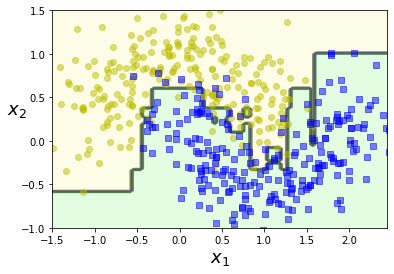

In [113]:
plot_decision_boundary(ada_clf, X, y)

샘플 가중치에 따른 SVC 시각화

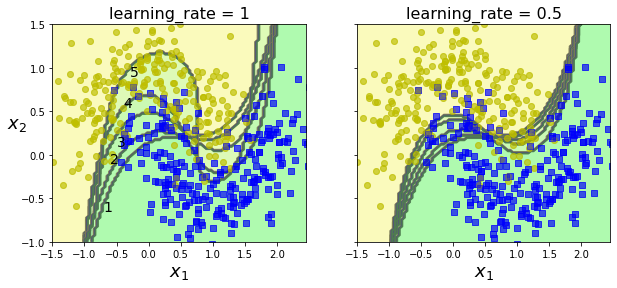

In [43]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights) ## 가중치 추가
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate) # 가중치 업데이트
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

In [50]:
ada_clf.estimator_weights_

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

- 모든 예측기의 가중치가 1로 동일하다. [가중치가 1인 이유](https://stackoverrun.com/ko/q/8808003)
- __algorithm="SAMME"__로 바꾸면, 예측기마다 다른 가중치 부여

### 에이다부스트 알고리즘

__가중치가 적용된 $j$번째 예측기의 에러율__

$
r_{j} = \frac{\sum_{\hat{y_{j}}^{(i)}\neq y^{(i)}}^{m}w^{(i)}}{\sum_{i=1}^{m}w^{(i)}}
$

- 샘플 가중치의 초기값은 $w^{(i)}=\frac{1}{m}$
- 여기서 $\hat{y_{j}}^{(i)}$는 $i$ 번째 샘플에 대한 $j$번째 예측기의 예측
- 모든 예측이 샘플의 레이블과 일치하면 $r_{j}=0$
- 모든 예측이 샘플의 레이블과 일치하지 않으면 $r_{j}=1$
- 예측기가 랜덤하게 분류하면 $r_{j}=\frac{1}{2}$


__예측기 가중치__

$
\alpha_{j} = \eta log\frac{1-r_{j}}{r_{j}}
$

- 예측이 정확할수록 가증치는 증가
- 랜덤하게 예측하면 가중치는 0
- 랜덤하게 예측하는것보다 나쁘면 가중치는 음수

__가중치 업데이트 규칙__

$
w^{(i)}=\begin{cases}
w^{(i)} & \hat{y_{j}}^{(i)}=y^{(i)}\\
w^{(i)}\text{exp}(\alpha_{j}) & \hat{y_{j}}^{(i)} \neq y^{(i)}
\end{cases}
$

- 위의 식처럼 가중치를 업데이트 한 후, 정규화한다(즉, $\sum_{i=1}^{m}w^{(i)}$로 나눈다.)
- 가중치가 업데이트되면 새로운 예측기를 훈련시킨다.
- 훈련 세트에 대해 완벽한 예측기가 만들어지거나, 지정된 예측기 수에 도달했을 때까지 위의 전체 과정을 반복

__에이다부스트 예측__

$
\hat{y}(\boldsymbol{\mathbf{x}}) = 
\text{argmax}_{k}\sum_{j=1}^{N}\alpha_{j}
$

- 각 클래스 별로 가중치 합을 구한다(즉, k개의 가중치 합을 구한다)
- k개의 가중치 합중 가장 큰 클래스가 예측결과가 된다.

## 그레디언트 부스팅

에이다부스트는 샘플의 가중치를 수정하는 방법이였다면, 그레디언트 부스트는 이전 예측기가 만든 __잔여 오차__에 새로운 예측기를 학습시키는 방법

트리회귀를 사용한 그레디언트 부스팅 예제

In [115]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [116]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [117]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [118]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [120]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

- 왜 모든 트리의 예측을 더하면 되는지는 아래 시각화 과정을 보고 이해하자.

In [121]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

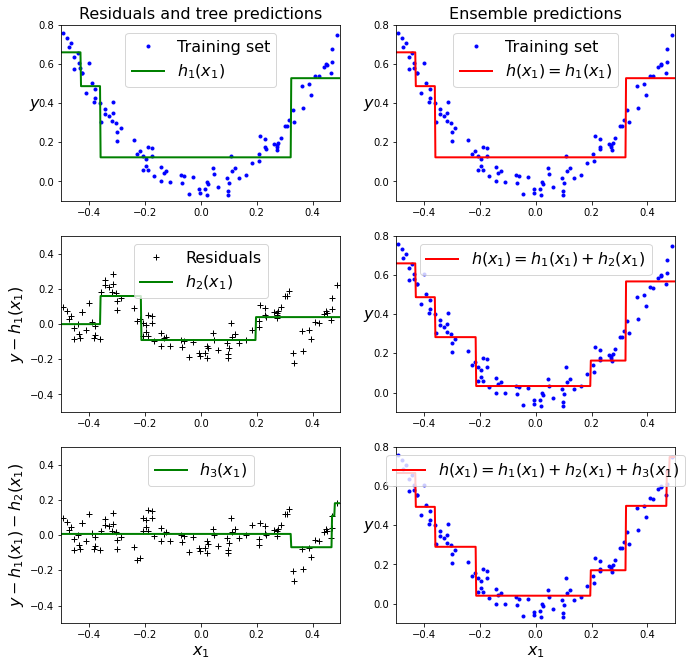

In [122]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

### 학습률에 따른 GBRT 시각화

In [154]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [155]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

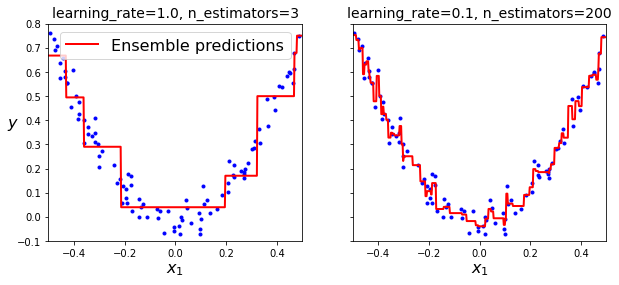

In [156]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

- 학습률이 낮아지면, 많은 트리가 필요하다.
- 왼쪽은 과소적합, 오른쪽은 과대적합

### 조기종료를 사용한 그레디언트 부스팅

__staged_predict()__ 메서드를 사용해 각 분류기의 예측 결과를 얻을 수 있음

In [157]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

# n_estimators=120이므로, errors의 길이는 120 
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)] 

bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [165]:
min_error = np.min(errors)
bst_n_estimators, min_error

(56, 0.002712853325235463)

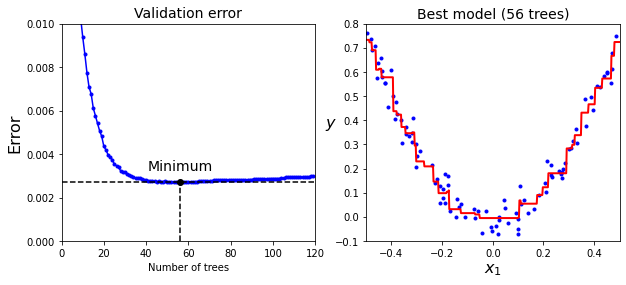

In [159]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

__warm_start=True__로 설정하면 기존 트리를 유지하고 훈련을 추가할 수 있음 <br>
다섯 번의 반복 동안 검증 오차가 향상되지 않으면 훈련을 멈춘다.

In [166]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [167]:
print(gbrt.n_estimators)

61


In [168]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


## XGBoost

최적화된 그레디언트 부스팅 구현

In [171]:
import xgboost

xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

[03:30:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBoost는 자동 조기 종료 기능 제공

In [172]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[03:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse